In [1]:
import sys
sys.path.append('/net/hypernova/data2/BOOMPJE/code/ic_generation/')

import numpy as np
import read_tipsy
import os
from astropy.cosmology import WMAP9 as cosmo

import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib
plt.rcParams['figure.dpi'] = 360
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['text.usetex'] = True
rc("animation", html = "jshtml")

In [50]:
def read_parameters(path):
    log = {}
    with open(f'/net/hypernova/data2/BOOMPJE/{path}/parameters.log') as f:
        for line in f:
            key, value = line.strip().split(':')
            try:
                log[key.strip()] = float(value.strip())
            except ValueError:
                log[key.strip()] = value.strip()
    return log

def separate_ids(sim_path):
    _, m, _, _, _, _, _, _, ids = read_tipsy.read_file(f'/net/hypernova/data2/BOOMPJE/{sim_path}/stacked_objects')
    return np.sort(ids[:int(1e6)])

def separate_halos(cen_ids, sim_path):
    _, m, x, y, z, vx, vy, vz, ids = read_tipsy.read_file(f'/net/hypernova/data2/BOOMPJE/{sim_path}')
    mask = np.isin(ids, cen_ids)
    halos = {
        'cen': {
            'pos': np.column_stack((x[mask], y[mask], z[mask])),
            'vel': np.column_stack((vx[mask], vy[mask], vz[mask])),
            'm': m[mask]},
        'sat': {
            'pos': np.column_stack((x[~mask], y[~mask], z[~mask])),
            'vel': np.column_stack((vx[~mask], vy[~mask], vz[~mask])),
            'm': m[~mask]}}
    return halos

def load_data(directory):
    direc = f'/net/hypernova/data2/BOOMPJE/{directory}'
    files = sorted(f for f in os.listdir(direc) if f.startswith('evolution'))
    time = [(1/15) * read_tipsy.read_file(f'{direc}/{file}')[0][0] * (1 / cosmo.H0.value) for file in files]
    return np.array(time), files

def find_dense_center_median(positions):
    return np.median(positions, axis=0)

def calculate_distances(positions, center):
    return np.linalg.norm(positions - center, axis=1)

def calculate_mass_density(distances, masses, num_bins=100):
    hist, bin_edges = np.histogram(distances, bins=num_bins, weights=masses)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_volumes = 4/3 * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
    return bin_centers, hist / bin_volumes

### 
---

### $r(t)$ behavior

In [44]:
def find_r(sim_path, ids, files):
    d = np.zeros(len(files))
    for i, f in enumerate(files):
        halos = separate_halos(ids, f'{sim_path}/{f}')
        median_center_cen = np.median(halos['cen']['pos'], axis=0)
        median_center_sat = np.median(halos['sat']['pos'], axis=0)
        d[i] = np.linalg.norm(median_center_cen - median_center_sat)
    return d

In [46]:
def find_tau_wt(path, threshold=1e-3):  #! 0.1% of the max ampl
    param = read_parameters(path)
    ids = separate_ids(path)
    t, t_files = load_data(path)
    r = find_r(path, ids, t_files)
    dr = np.gradient(r, t)
    ddr = np.gradient(dr, t)
    threshold = threshold*max(ddr)
    index = int(np.median(np.where(np.abs(ddr) < threshold)))
    return r, t, index

#### Changing the number of particles used to calculate the center

In [51]:
def separate_halos_mod(cen_ids, sim_path, n):
    _, m, x, y, z, vx, vy, vz, ids = read_tipsy.read_file(f'/net/hypernova/data2/BOOMPJE/{sim_path}')
    mask = np.isin(ids, cen_ids)
    ind = int(len(mask)*n)
    halos = {
        'cen': {
            'pos': np.column_stack((x[mask], y[mask], z[mask]))[:ind],
            'vel': np.column_stack((vx[mask], vy[mask], vz[mask]))[:ind],
            'm': m[mask][:ind]},
        'sat': {
            'pos': np.column_stack((x[~mask], y[~mask], z[~mask]))[:ind],
            'vel': np.column_stack((vx[~mask], vy[~mask], vz[~mask]))[:ind],
            'm': m[~mask][:ind]}}
    return halos

def find_r_mod(sim_path, ids, files, n):
    d = np.zeros(len(files))
    for i, f in enumerate(files):
        halos = separate_halos_mod(ids, f'{sim_path}/{f}', n)
        median_center_cen = np.median(halos['cen']['pos'], axis=0)
        median_center_sat = np.median(halos['sat']['pos'], axis=0)
        d[i] = np.linalg.norm(median_center_cen - median_center_sat)
    return d

def find_tau_wt_mod(path, n):
    param = read_parameters(path)
    ids = separate_ids(path)
    t, t_files = load_data(path)
    r = find_r_mod(path, ids, t_files, n)
    dr = np.gradient(r, t)
    ddr = np.gradient(dr, t)
    threshold = 1e-3*max(ddr)  #! 0.1% of the max ampl
    try:
        index = int(np.median(np.where(np.abs(ddr) < threshold)))
    except IndexError:
        index = -1
    return r, t, index

In [ ]:
test = np.linspace(0,1,5)
array = []
for t in test:
    r, t, idx = find_tau_wt_mod('merging_0_1072098', t)
    array.append([r,t,idx])

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

for i in range(len(test)):
    data = array[i]
    if test[i]!=0.0:
        ax.plot(data[1], data[0], label=f'{test[i]}')

ax.set_xlabel('$t/tau$')
ax.set_ylabel('$r$')
plt.title('merging_0_1072098')
plt.legend()
plt.show()

### $\tau (r_p)$

In [6]:
param = read_parameters('merging_0_1072098')
param['pericentre_distance']

0.0963719784950555

In [7]:
files = [f for f in os.listdir('/net/hypernova/data2/BOOMPJE/') if f.startswith('merging')]

In [39]:
test = np.random.randint(0,498,5)
ls = []
for f in files:
    if (f[10]=='_'):
        if (int(f[8:10]) in test):
            ls.append(f)
    elif (f[9]=='_'):
        if (int(f[8]) in test):
            ls.append(f)
    elif (int(f[8:11]) in test):
        ls.append(f)

In [40]:
test, ls

(array([196, 288, 166, 340, 444]),
 ['merging_166_1073712',
  'merging_196_1073716',
  'merging_288_1073714',
  'merging_340_1073715'])

In [48]:
tau, r_p = [], []
for l in ls:
    print(l)
    r_p.append(read_parameters(l)['pericentre_distance'])
    _, t, idx = find_tau_wt(l)
    tau.append(t[idx])

merging_166_1073712
merging_196_1073716
merging_288_1073714
merging_340_1073715


In [55]:
tau.sort()
r_p.sort()

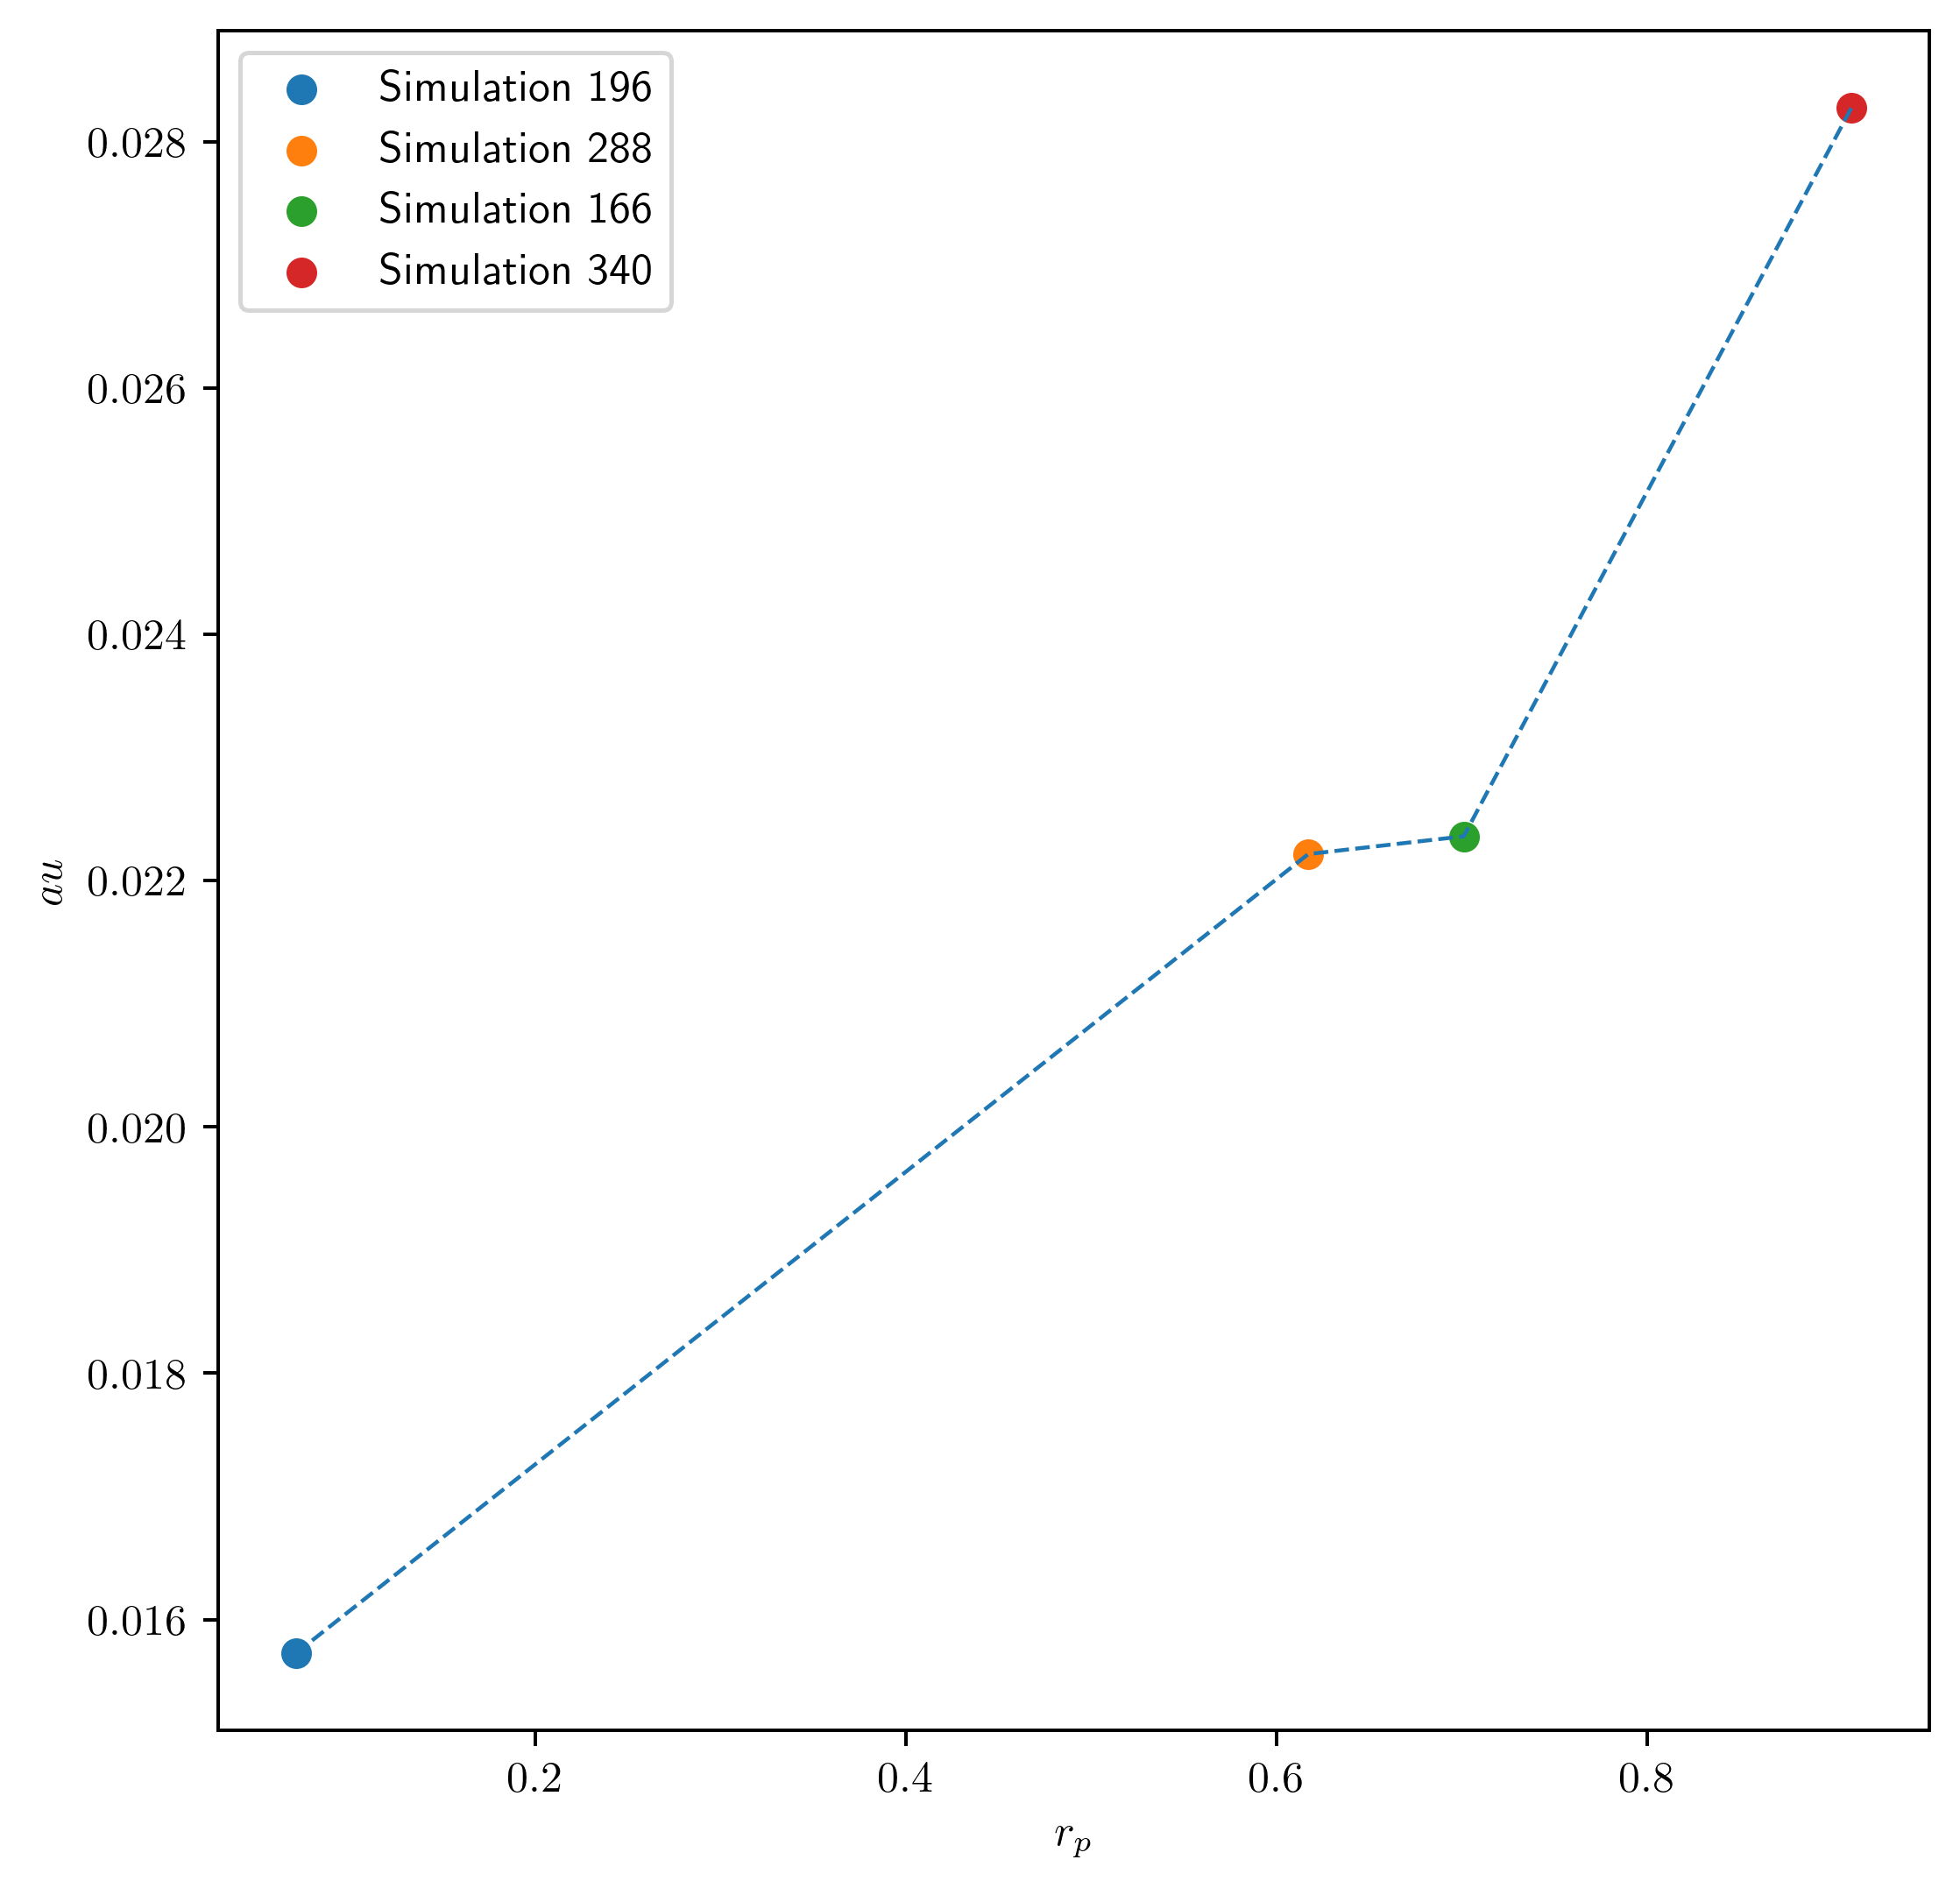

In [59]:
fig, ax = plt.subplots(figsize=(7, 7))
for i in range(len(tau)):
    plt.scatter(r_p[i], tau[i], label=f'Simulation {test[i]}')
plt.plot(r_p, tau, ls='--', lw=0.9)
ax.set_ylabel('$\tau$')
ax.set_xlabel('$r_p$')
plt.legend()
plt.show()